## LAB 2 - TASK 1 submission. ML 2023-24.
FILL UP THIS BOX WITH YOUR DETAILS

**NAME AND NIP**:

Eryka Liced Rimacuna Castillo 816778

Luis Catalan Salas            774274



**SOURCE: This colab is based on the materials from Stanford Course - CS231CNNs for Visual Recognition with CNN by Fei-Fei Li**

You should **run this Colab in an instance WITHOUT GPU**! (recommended to save your GPU time)



# Implementing a Neural Network

In [ ]:
# DEFINITION OF THE CLASS for the 2-layer NN
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network that performs classification over C classes.
  The network has the following architecture:
  input - fully connected layer - ReLU - fully connected layer - softmax
  Input dimension of N, hidden layer dimension of H.
  Training uses a softmax loss function and L2 regularization (on the weights).

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights to small random values and biases to zero.
    Weights and biases are stored in the variable self.params,
    which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs to configure our network:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)


  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C.
      If it is None we only return scores; else return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function (with the same keys as self.params)
    """

    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape


    ## BEGINING OF FORWARD PASS ##
    # Q2. What's done in this block? (one line comment)
    # It computes the intermediate and final output scores by propagating the input data though the layers
    # Compute the forward pass
    scores = None
    fc1 = X.dot(W1) + b1     # type of layer? fully connected
    X2 = np.maximum(0, fc1)  # type of layer? ReLU
    scores = X2.dot(W2) + b2 # type of layer? fully connected

    # If labels are not given skip the rest
    if y is None:
      return scores

    # Q3. What's done in this block? (one line comment)
    # It computes the loss, including the data loss from softmax and the L2 regularization loss for the weights.
    # Compute the loss (data loss - Softmax and L2 regularization)
    loss = None
    scores -= np.max(scores, axis=1, keepdims=True) # avoid numeric instability
    scores_exp = np.exp(scores)
    softmax_matrix = scores_exp / np.sum(scores_exp, axis=1, keepdims=True)
    loss = np.sum(-np.log(softmax_matrix[np.arange(N), y]))
    loss /= N
    loss += reg * (np.sum(W2 * W2) + np.sum( W1 * W1 ))

    ## BEGINING OF BACKWARD PASS ##
    # Backward pass: compute gradients (derivatives of the weights and biases).
    # Fill up grads dictionary,
    # e.g., grads['W1'] is the gradient on W1 and both have the same size
    grads = {}
    softmax_matrix[np.arange(N) ,y] -= 1
    softmax_matrix /= N
    # W2 gradient
    dW2 = X2.T.dot(softmax_matrix)   # [HxN] * [NxC] = [HxC]
    # b2 gradient
    db2 = softmax_matrix.sum(axis=0)
    # W1 gradient
    dW1 = softmax_matrix.dot(W2.T)   # [NxC] * [CxH] = [NxH]
    dfc1 = dW1 * (fc1>0)             # [NxH] . [NxH] = [NxH]
    dW1 = X.T.dot(dfc1)              # [DxN] * [NxH] = [DxH]
    # b1 gradient
    db1 = dfc1.sum(axis=0)
    # regularization gradient
    dW1 += reg * 2 * W1
    dW2 += reg * 2 * W2

    grads = {'W1':dW1, 'b1':db1, 'W2':dW2, 'b2':db2}
    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    """
    Q4. WHAT IS THIS FUNCTION DOING?
    This function trains the neural network using SGD.
     It iteratively updates the model's parameters based on mini-batches of training data,
     computes the loss, and adjusts the weights using the calculated gradients.
     It also evaluates and stores training and validation accuracy at each epoch.
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      # Q5. What's being done in this block? (one line comment)
      # It selects a random batch size to do stochastic gradient descent
      # random minibatch of training data and labels in X_batch and y_batch
      batch_indices = np.random.choice(num_train, batch_size)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      # Q6. What's being done in this block? (one line comment)
      # It update the model's parameters using the gradients computed on the block before using SGD. Also update the value of the learning rate
      # With the gradients in the grads dictionary, update the network params using SGD.
      for key in self.params:
        self.params[key] -= learning_rate * grads[key]

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None
    #y_pred = np.argmax( self.function1(X), axis=1)
    y_pred = np.argmax( self.loss(X), axis=1)

    return y_pred

**Q2. What's done in this block? (one line comment)**

It computes the intermediate and final output scores by propagating the input data through the layers.

**Q3. What's done in this block? (one line comment)**

It computes the loss, including the softmax data loss and the L2 regularization loss for the weights.

**Q4. WHAT IS THIS FUNCTION DOING?**

It trains the neural network using SGD, updating parameters with gradients, tracking accuracy, and decaying the learning rate.

# Using the NN

# Load a real dataset
Now train the network on CIFAR-10

In [ ]:
from tensorflow.keras.datasets import cifar10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 dataset
    data_cifar10 = cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = data_cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

In [ ]:
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)



iteration 0 / 1000: loss 2.302970
iteration 100 / 1000: loss 2.302512
iteration 200 / 1000: loss 2.298487
iteration 300 / 1000: loss 2.261957
iteration 400 / 1000: loss 2.229121
iteration 500 / 1000: loss 2.164273
iteration 600 / 1000: loss 2.057103
iteration 700 / 1000: loss 2.079291
iteration 800 / 1000: loss 2.009133
iteration 900 / 1000: loss 1.988829
Validation accuracy:  0.288


# Debug the training
With the default parameters provided above, you should get a validation accuracy of about 0.20 on the validation set.

This isn't very good. Keep reading to improve the training.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

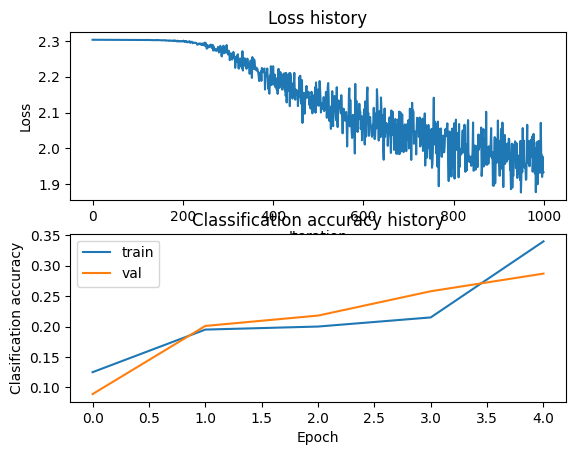

In [ ]:
# Plot the loss function and train / validation accuracies

def plot_stats(stats):
  plt.subplot(2, 1, 1)
  plt.plot(stats['loss_history'])
  plt.title('Loss history')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

  plt.subplot(2, 1, 2)
  plt.plot(stats['train_acc_history'], label='train')
  plt.plot(stats['val_acc_history'], label='val')
  plt.title('Classification accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Clasification accuracy')
  plt.legend()
  plt.show()

plot_stats(stats)
print(stats['train_acc_history'])
print(stats['val_acc_history'])

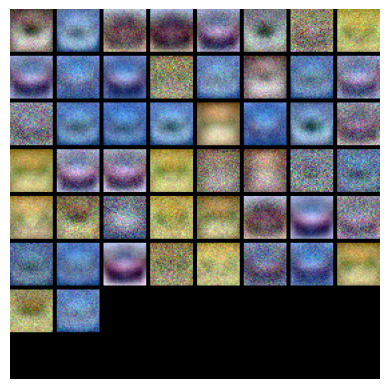

In [ ]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What can be wrong?**. In the visualizations above we see that the loss is decreasing more or less linearly which could be do to a learning rate too low. Besides, there is no significant gap between the training and validation accuracy, suggesting that the model used has low capacity, and we could increase its size. However, we need to be careful with very large models, where we would expect to see more overfitting. This can manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks.
To try to improve the results, next you will:
- run the training for more iterations (now we use 2000 instead of 1000)
- experiment with different values of  hidden layer size, learning rate and regularization strength.

Expect to achieve at most around 50% on the validation set. It's ok if you don't get to that. Just explain which hyperparameters you consider and why in the following question.






### **QUESTION 1** What list of possible values for lr, h and reg do you consider? why?


We consider this values:
 * Learning rates (lr): [1e-04, 1e-03, 1e-02] to explore a wide range of values from slow to fast learning.
 * Hidden layer sizes (h): [50, 100, 150] to test smaller to moderately large networks.
 * Regularization strengths (reg): [0.25, 0.5, 0.75] to evaluate under to  strong regularization and find the optimal to prevent overfitting.



In [ ]:
# This code explores different sets of hyperparameters and stores the best configuration

best_net = None # store the best model into this
best_val = -1
best_stats = []

# generate random hyperparameters given ranges for each of them
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# get random hyperparameters given arrays of potential values
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden

input_size = 32 * 32 * 3
num_classes = 10

############### ************* TO-DO-IN-LAB ************* ###############
num_random_iterations = 20   #When you have your lists of possible values ready, increase this to 20
lr_value_list = [0.0001, 0.001, 0.01]    # This is the initial value, add a list with up to 3 possible values
str_value_list = [0.25, 0.5, 0.75]     # This is the initial value, add a list with up to 3 possible values
h_value_list = [50, 100, 150]         # This is the initial value, add a list with up to 3 possible values
############### ************* END of TO-DO-IN-LAB ************* ###############

# Set a seed for results reproduction
np.random.seed(0)

# Use of random search for hyperparameter search
for i in range(num_random_iterations):
    lr, reg, hidden_size = random_search_hyperparams(lr_value_list, str_value_list, h_value_list)

    # Create a two-layer network
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train) == y_train).mean()

    # Predict on the validation set
    val_accuracy = (net.predict(X_val) == y_val).mean()

    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats

    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)


lr 1.000000e-04 reg 5.000000e-01 hid 50  train accuracy: 0.356286 val accuracy: 0.360000


<ipython-input-1-79bc71cc9e17>:89: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax_matrix[np.arange(N), y]))
<ipython-input-1-79bc71cc9e17>:86: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True) # avoid numeric instability
<ipython-input-1-79bc71cc9e17>:86: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True) # avoid numeric instability


lr 1.000000e-02 reg 7.500000e-01 hid 150  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-02 reg 2.500000e-01 hid 100  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-03 reg 2.500000e-01 hid 150  train accuracy: 0.549184 val accuracy: 0.507000
lr 1.000000e-03 reg 5.000000e-01 hid 150  train accuracy: 0.534980 val accuracy: 0.505000
lr 1.000000e-04 reg 7.500000e-01 hid 100  train accuracy: 0.359020 val accuracy: 0.364000
lr 1.000000e-03 reg 5.000000e-01 hid 100  train accuracy: 0.530082 val accuracy: 0.497000
lr 1.000000e-04 reg 5.000000e-01 hid 100  train accuracy: 0.360551 val accuracy: 0.366000
lr 1.000000e-04 reg 5.000000e-01 hid 150  train accuracy: 0.364796 val accuracy: 0.367000
lr 1.000000e-02 reg 2.500000e-01 hid 100  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-02 reg 7.500000e-01 hid 50  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-04 reg 2.500000e-01 hid 150  train accuracy: 0.367633 val accuracy: 0.371000
lr 1.000000

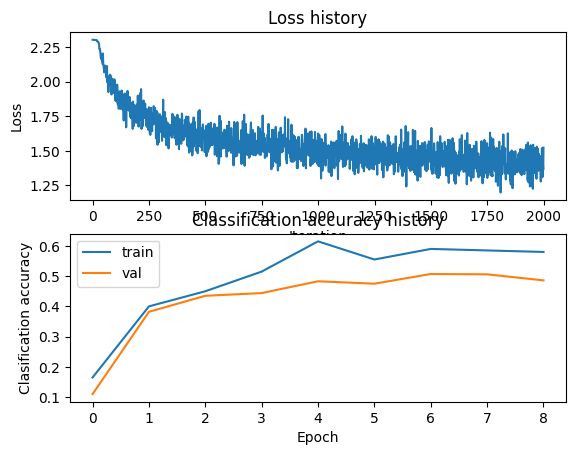

In [ ]:
# Plot the loss function and train / validation accuracies
plot_stats(best_stats)

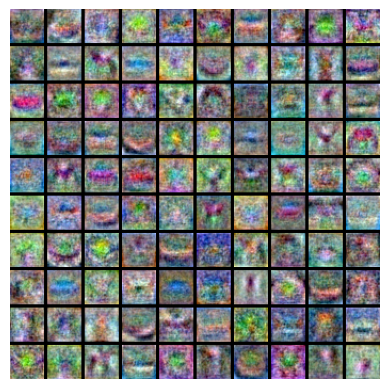

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [ ]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.4986


### **QUESTION 2**
When you find that your testing accuracy is much lower than the training accuracy. What can you do to try to fix it? Select all that apply and explain why (max 4 lines).
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. Start with very low values of learning rate
5. None of the above.

ANSWER 2:

1: Reduces overfitting by exposing it to more diverse examples.

2. Prevents the model from overfitting by constraining the weights, improving performance on unseen data.

3. Depends. Increases the model's capacity, but it may exacerbate overfitting if the dataset is small.



# OPTIONAL

In [ ]:
from google.colab import drive
from PIL import Image
import os
from tqdm import tqdm
import shutil
import numpy as np

def load_images_from_folder(image_names, image_folder):
    X_images = []
    for image_name in tqdm(image_names, desc="Loading images"):  # Añadimos tqdm aquí
        image_path = os.path.join(image_folder, image_name + '.jpg')  # Asegúrate de que la extensión sea correcta
        try:
            image = Image.open(image_path).convert("RGB")  # Convertir a RGB en caso de que haya imágenes en escala de grises
            X_images.append(image)
        except FileNotFoundError:
            print(f"Warning: {image_path} not found.")
    return X_images

drive.mount('/content/drive')
folder = '/content/drive/MyDrive/Master/Practicas_ML/Practica4_816778_774272/'
image_folder = folder + 'images'


file_train_val = folder + 'trainval.txt'
test_name = folder + 'test.txt'
list_name = folder + 'list.txt'

with open(list_name, 'r') as f:
    list_data_name = f.readlines()


def extract_x_y(file_read, selected_classes=None):
  X = []
  Y = []
  for line in file_read:
      if line.startswith("#"):
          continue  # Saltar comentarios
      parts = line.split()
      image_name = parts[0]
      class_id = int(parts[1])

      if selected_classes is None:
        X.append(image_name)
        Y.append(class_id)
      else:
        if class_id in selected_classes:
          X.append(image_name)
          Y.append(class_id)


  return X, Y

selected_classes = [1, 2, 3, 4, 6]
X, Y = extract_x_y(list_data_name, selected_classes)

X_images = load_images_from_folder(X, image_folder)
print(f"Total de imágenes cargadas: {len(X_images)}")


Mounted at /content/drive


Loading images: 100%|██████████| 998/998 [06:42<00:00,  2.48it/s]

Total de imágenes cargadas: 998


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

def preprocess_images(X_images, y_labels, target_size=(32, 32), test_size=0.1, val_size=0.1):
    """
    Preprocess and split images into train, validation, and test sets.

    Args:
        X_images (list): List of images (loaded using `load_images_from_folder`).
        y_labels (list or np.array): Corresponding labels for the images.
        test_size (float): Fraction of the dataset to reserve for the test set.
        val_size (float): Fraction of the dataset to reserve for the validation set.

    Returns:
        Tuple of preprocessed and split datasets: X_train, y_train, X_val, y_val, X_test, y_test
    """
    X_images = [img.resize(target_size) for img in X_images]

    # Convert images to NumPy arrays
    X_images = np.array([np.array(img) for img in X_images], dtype=np.float32)
    y_labels = np.array(y_labels, dtype=np.int32)

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_images, axis=0)
    X_images -= mean_image

    # Split into train + val/test and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_images, y_labels, test_size=test_size, random_state=42, stratify=y_labels
    )

    # Split train + val into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size / (1 - test_size), random_state=42, stratify=y_train_val
    )

    # Flatten the data if needed for a fully connected network
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


Y = [0 if label == 6 else label for label in Y]
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_images(X_images, Y, test_size=0.1, val_size=0.1)

# Check the shapes
print("Train data shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation y shape:", y_val.shape)
print("Test data shape:", X_test.shape)
print("Test y shape:", y_test.shape)


Train data shape: (798, 3072)
Train y shape: (798,)
Validation data shape: (100, 3072)
Validation y shape: (100,)
Test data shape: (100, 3072)
Test y shape: (100,)


In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 5
net = TwoLayerNet(input_size, hidden_size, num_classes)

In [ ]:
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=32,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 1.609800
iteration 100 / 1000: loss 1.609667
iteration 200 / 1000: loss 1.608834
iteration 300 / 1000: loss 1.598897
iteration 400 / 1000: loss 1.594514
iteration 500 / 1000: loss 1.494461
iteration 600 / 1000: loss 1.452564
iteration 700 / 1000: loss 1.547855
iteration 800 / 1000: loss 1.388009
iteration 900 / 1000: loss 1.367993
Validation accuracy:  0.35


In [ ]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

# Plot the loss function and train / validation accuracies
def plot_stats(stats):
  plt.subplot(2, 1, 1)
  plt.plot(stats['loss_history'])
  plt.title('Loss history')
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

  plt.subplot(2, 1, 2)
  plt.plot(stats['train_acc_history'], label='train')
  plt.plot(stats['val_acc_history'], label='val')
  plt.title('Classification accuracy history')
  plt.xlabel('Epoch')
  plt.ylabel('Clasification accuracy')
  plt.legend()
  plt.show()

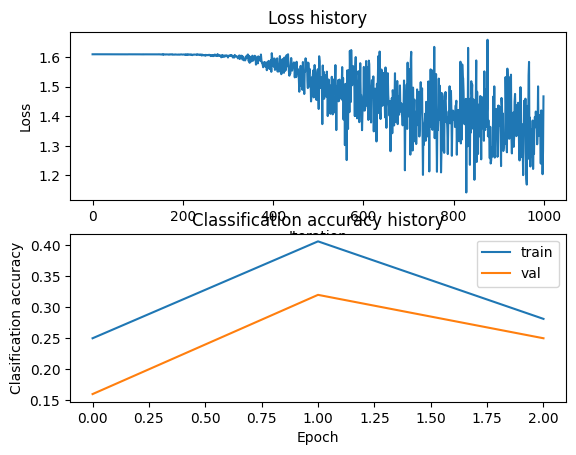

In [ ]:
plot_stats(stats)

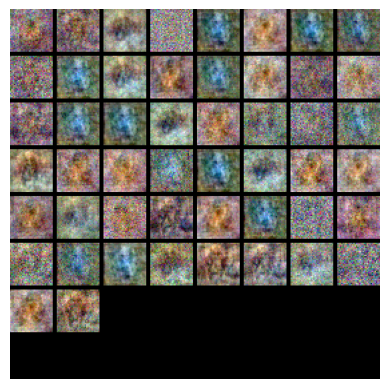

In [ ]:
show_net_weights(net)

In [ ]:
# This code explores different sets of hyperparameters and stores the best configuration

best_net = None # store the best model into this
best_val = -1
best_stats = []

# generate random hyperparameters given ranges for each of them
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# get random hyperparameters given arrays of potential values
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden

input_size = 32 * 32 * 3
num_classes = 5

############### ************* TO-DO-IN-LAB ************* ###############
num_random_iterations = 20   #When you have your lists of possible values ready, increase this to 20
lr_value_list = [0.0001, 0.001, 0.01]    # This is the initial value, add a list with up to 3 possible values
str_value_list = [0.25, 0.5, 0.75]     # This is the initial value, add a list with up to 3 possible values
h_value_list = [50, 100, 150]         # This is the initial value, add a list with up to 3 possible values
############### ************* END of TO-DO-IN-LAB ************* ###############

# Set a seed for results reproduction
np.random.seed(0)

# Use of random search for hyperparameter search
for i in range(num_random_iterations):
    lr, reg, hidden_size = random_search_hyperparams(lr_value_list, str_value_list, h_value_list)

    # Create a two-layer network
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=1000, batch_size=100,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train) == y_train).mean()

    # Predict on the validation set
    val_accuracy = (net.predict(X_val) == y_val).mean()

    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats

    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)


lr 1.000000e-04 reg 5.000000e-01 hid 50  train accuracy: 0.446115 val accuracy: 0.320000
lr 1.000000e-04 reg 2.500000e-01 hid 50  train accuracy: 0.443609 val accuracy: 0.310000
lr 1.000000e-04 reg 2.500000e-01 hid 100  train accuracy: 0.463659 val accuracy: 0.380000
lr 1.000000e-04 reg 2.500000e-01 hid 50  train accuracy: 0.439850 val accuracy: 0.320000


<ipython-input-14-79bc71cc9e17>:89: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax_matrix[np.arange(N), y]))
<ipython-input-14-79bc71cc9e17>:86: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True) # avoid numeric instability
<ipython-input-14-79bc71cc9e17>:86: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores, axis=1, keepdims=True) # avoid numeric instability


lr 1.000000e-02 reg 5.000000e-01 hid 50  train accuracy: 0.200501 val accuracy: 0.200000
lr 1.000000e-04 reg 2.500000e-01 hid 100  train accuracy: 0.479950 val accuracy: 0.390000
lr 1.000000e-02 reg 5.000000e-01 hid 50  train accuracy: 0.200501 val accuracy: 0.200000
lr 1.000000e-03 reg 5.000000e-01 hid 100  train accuracy: 1.000000 val accuracy: 0.430000
lr 1.000000e-02 reg 2.500000e-01 hid 100  train accuracy: 0.200501 val accuracy: 0.200000
lr 1.000000e-04 reg 5.000000e-01 hid 150  train accuracy: 0.484962 val accuracy: 0.380000
lr 1.000000e-03 reg 5.000000e-01 hid 100  train accuracy: 1.000000 val accuracy: 0.480000
lr 1.000000e-03 reg 2.500000e-01 hid 100  train accuracy: 1.000000 val accuracy: 0.420000
lr 1.000000e-04 reg 7.500000e-01 hid 100  train accuracy: 0.462406 val accuracy: 0.350000
lr 1.000000e-02 reg 2.500000e-01 hid 50  train accuracy: 0.200501 val accuracy: 0.200000
lr 1.000000e-03 reg 5.000000e-01 hid 100  train accuracy: 1.000000 val accuracy: 0.410000
lr 1.000000e-

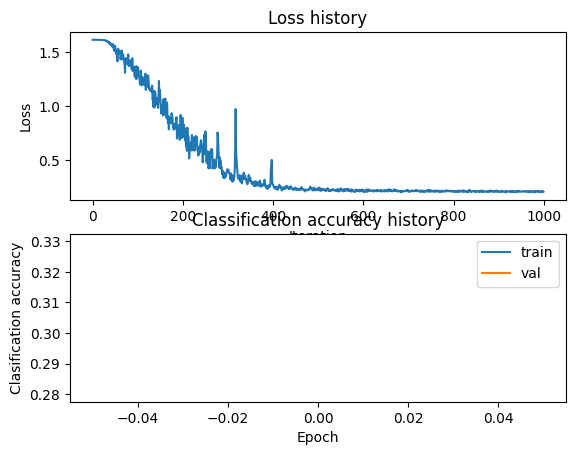

{'loss_history': [1.6109546134972075, 1.6109342966166658, 1.6108712179902303, 1.6108533399240337, 1.6109124154395198, 1.6108637891104223, 1.6107684690790398, 1.6107231609364205, 1.6107077657023596, 1.6107318984053158, 1.6106798784014476, 1.61049663216189, 1.6104406647682055, 1.6103070778264772, 1.6104775697330045, 1.6100658643190342, 1.609903631040403, 1.6098922670725955, 1.609524338222059, 1.6089397211120893, 1.6093380175025702, 1.6084197089040693, 1.6081291386128258, 1.608150200225562, 1.6066784932201068, 1.606315582863779, 1.6067378311835467, 1.6054686582163338, 1.6066618901413545, 1.6021035005831237, 1.6002941071373016, 1.6026743972016975, 1.5941197890796097, 1.5962512290614115, 1.5896580591353635, 1.5926515642377659, 1.5853868367755053, 1.574871816880119, 1.58638772359882, 1.5836151598942085, 1.5674008133802, 1.5706630252140144, 1.5572347121373677, 1.550100319037733, 1.5472493103736171, 1.5718429681325075, 1.559236539385951, 1.5184485041024647, 1.5238564280228808, 1.50497153504429

In [ ]:
plot_stats(best_stats)
print(best_stats)

In [ ]:

print(best_stats['train_acc_history'])
print(best_stats['val_acc_history'])


[0.33]
[0.28]


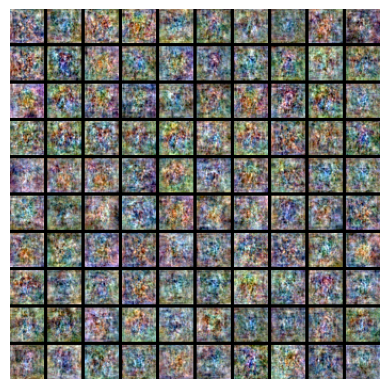

In [ ]:
show_net_weights(best_net)


Test Loss: 2.2790530235634456
Test Accuracy: 0.3500
Aciertos: 35/100 = 0.3500


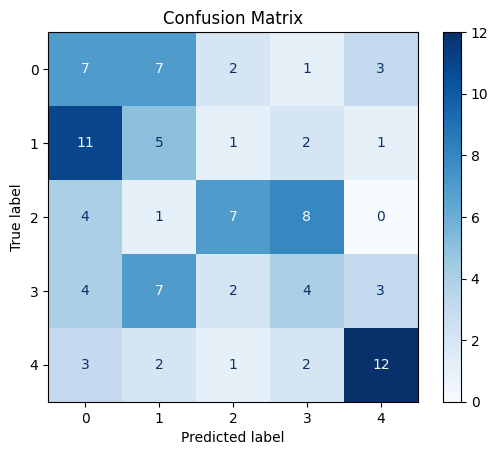

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluar el modelo en los datos de prueba
test_loss = best_net.loss(X_test, y_test, reg=0.0)[0]  # Solo obtener el valor de la pérdida
y_pred = best_net.predict(X_test)  # Obtener predicciones
test_accuracy = (y_pred == y_test).mean()  # Calcular la precisión

# Imprimir resultados
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular el número de predicciones correctas (aciertos)
correct_predictions = np.trace(conf_matrix)  # Suma de los elementos diagonales
total_predictions = np.sum(conf_matrix)  # Total de muestras

# Imprimir aciertos/total
print(f"Aciertos: {correct_predictions}/{total_predictions} = {correct_predictions/total_predictions:.4f}")

# Número de clases
num_classes = len(np.unique(y_test))

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


#Conclusion
The results show a low accuracy of 35%, indicating poor performance. This is likely due to the use of a 2-layer neural network with flattened 2D images, which loses important spatial information. Consequently, this type of network is not suitable for image classification tasks.

The confusion matrix highlights significant misclassification between cats (classes 0, 1) and dogs (classes 2, 3, 4). Class 4 (dogs) performs best with 12 correct predictions, while other classes, particularly 1 and 2, are frequently confused. The model struggles not only to distinguish between cats and dogs but also among the dog classes, further demonstrating the limitations of this network and the flattened image representation.